In [18]:
# 利用tushare获取股票数据
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
token = '7871394b0313e30c7da48d0f9b203f507ccea509ff8cb5e6fbbcfcdd'

assert ts.__version__ != '1.2.10'
ts.set_token(token)
pro = ts.pro_api()

def wash(df):# df: DATAFRAME  output:处理后的结果
    df = df.reset_index(drop=True)
    df = df.sort_index(ascending=False)
    col_list = df.columns.tolist()
    col_list.remove('ts_code')# 交易所代码无用
    col_list.remove('trade_date')# 交易日期无用
    col_list.remove('pre_close')# 昨天收盘价格无用
    col_list.remove('change')# 涨跌额无用数据
    col_list.remove('pct_chg')# 涨跌幅无用数据
    col_list.remove('close')# 将当天闭市价格作为预测目标
    col_list.append('close')
    return df[col_list]

def get_all_years(stock_id , start_year , end_date, autype=None):
    df = pro.query('daily',ts_code=stock_id,start_date=start_year, end_date=end_date)
    tradedate = df['trade_date']
    df = wash(df)
    print('Saving DataFrame: \n',df.head(5))
    df.to_csv('{}-all-year.csv'.format(stock_id),index=False)
    return tradedate

# 600519.SH茅台上证指数
stock_id = '600519.SH'
start_date = '20010827'# 20010827挂牌上市
end_date = '20220516'
tradedate = get_all_years(stock_id,start_date,end_date)


Saving DataFrame: 
        open   high    low        vol       amount  close
4949  34.51  37.78  32.85  406318.00  1410347.179  35.55
4948  34.99  37.00  34.61  129647.79   463463.143  36.86
4947  36.98  37.00  36.10   53252.75   194689.620  36.38
4946  36.28  37.51  36.00   48013.06   177558.558  37.10
4945  37.15  37.62  36.80   23231.48    86231.237  37.01


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import datetime


df = pd.read_csv('600519.SH-all-year.csv')# 读数据
df.head()

,open,high,low,vol,amount,close
0,34.51,37.78,32.85,406318.00,1410347.179,35.55
1,34.99,37.00,34.61,129647.79,463463.143,36.86
2,36.98,37.00,36.10,53252.75,194689.620,36.38
3,36.28,37.51,36.00,48013.06,177558.558,37.10
4,37.15,37.62,36.80,23231.48,86231.237,37.01


In [20]:
'''
读取原始数据，并生成训练样本
df             : 原始数据
column         : 要处理的列
train_end      : 训练集的终点
days_before    : 预测天数
return_all     : 是否返回所有数据，默认 True
generate_index : 是否生成 index
'''
def getData(df, column, train_end=-300, days_before=30, return_all=True, generate_index=False):
    
    series = df[column].copy()
    
    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series, test_series = series[:train_end], series[train_end - days_before:]
    
    # 创建训练集
    train_data = pd.DataFrame()
        
    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
        # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
        # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
        # 比如从 [2:-7+2]，其长度为 len - 7
        train_data['c%d' % i] = train_series.tolist()[i: -days_before + i]
            
    # 获取对应的 label
    train_data['y'] = train_series.tolist()[days_before:]
        
                
    if return_all:
        return train_data, series, df.index.tolist()
    
    return train_data

In [21]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = 1,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )
        self.out = nn.Sequential(nn.Linear(64,1))
    
    def forward(self,x):
        r_out, (h_n,h_c) = self.lstm(x,None)
        # print(r_out)
        # print(r_out.shape)
        out = self.out(r_out[:,-1,:])
        return out


In [22]:
class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [23]:
# 参数
LR = 0.0001
EPOCH = 100
TRAIN_END=-300
DAYS_BEFORE=7
# print(tradedate.sort_index(ascending=False))
tradedate = tradedate.sort_index(ascending=False)
for i in range(len(tradedate)):
    tradedate[i] = datetime.datetime.strptime(tradedate[i],'%Y%m%d').date()
# print(type(datetime.datetime.strptime(tradedate[0],'%Y%m%d')),datetime.datetime.strptime(tradedate[0],'%Y%m%d').date())
print(tradedate)

4949    2001-08-27
4948    2001-08-28
4947    2001-08-29
4946    2001-08-30
4945    2001-08-31
           ...    
4       2022-05-10
3       2022-05-11
2       2022-05-12
1       2022-05-13
0       2022-05-16
Name: trade_date, Length: 4950, dtype: object


4949    2001-08-27
4948    2001-08-28
4947    2001-08-29
4946    2001-08-30
4945    2001-08-31
           ...    
4       2022-05-10
3       2022-05-11
2       2022-05-12
1       2022-05-13
0       2022-05-16
Name: trade_date, Length: 4950, dtype: object


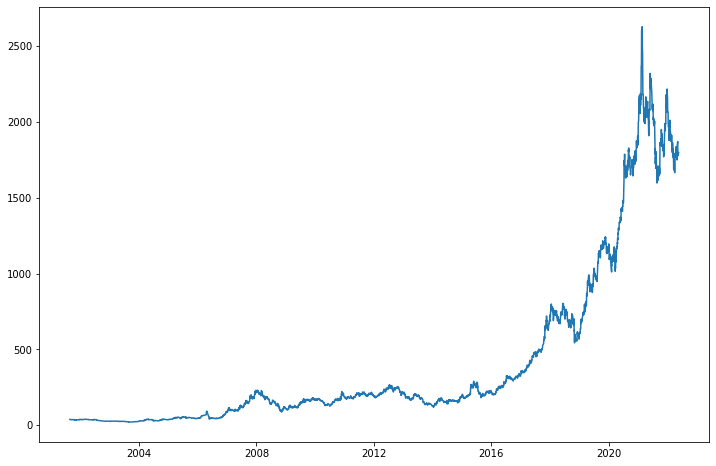

In [24]:
# 获取数据
train_data, all_series, df_index = getData(df, 'high', days_before=DAYS_BEFORE, train_end=TRAIN_END)
# print(df_index)
# 获取所有原始数据
all_series = np.array(all_series.tolist())
# tradedate = np.array(tradedate.tolist())
print(tradedate)
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(tradedate, all_series, label='real-data')

# 归一化，便于训练
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

# 创建 dataloader
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [25]:
lstm = LSTM()

if torch.cuda.is_available():
    lstm = lstm.cuda()

optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in train_loader:
        
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()       
        
        output = lstm(torch.unsqueeze(tx, dim=2))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(lstm, 'lstm.pkl')
torch.save(lstm, 'lstm.pkl')

0 tensor(0.0233, grad_fn=<MseLossBackward0>)
1 tensor(0.0067, grad_fn=<MseLossBackward0>)
2 tensor(0.0012, grad_fn=<MseLossBackward0>)
3 tensor(0.0059, grad_fn=<MseLossBackward0>)
4 tensor(0.0005, grad_fn=<MseLossBackward0>)
5 tensor(0.0118, grad_fn=<MseLossBackward0>)
6 tensor(0.0002, grad_fn=<MseLossBackward0>)
7 tensor(0.0022, grad_fn=<MseLossBackward0>)
8 tensor(0.0005, grad_fn=<MseLossBackward0>)
9 tensor(0.0001, grad_fn=<MseLossBackward0>)
10 tensor(0.0002, grad_fn=<MseLossBackward0>)
11 tensor(0.0006, grad_fn=<MseLossBackward0>)
12 tensor(0.0012, grad_fn=<MseLossBackward0>)
13 tensor(0.0023, grad_fn=<MseLossBackward0>)
14 tensor(4.0567e-05, grad_fn=<MseLossBackward0>)
15 tensor(0.0001, grad_fn=<MseLossBackward0>)
16 tensor(0.0052, grad_fn=<MseLossBackward0>)
17 tensor(7.1867e-05, grad_fn=<MseLossBackward0>)
18 tensor(0.0029, grad_fn=<MseLossBackward0>)
19 tensor(0.0002, grad_fn=<MseLossBackward0>)
20 tensor(0.0002, grad_fn=<MseLossBackward0>)
21 tensor(0.0006, grad_fn=<MseLossBa

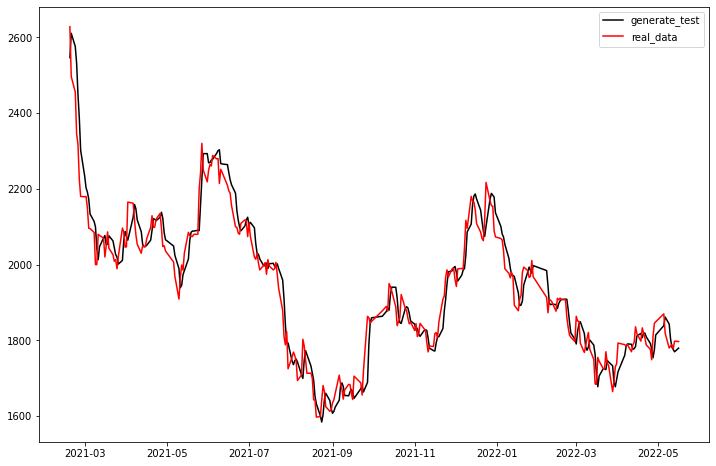

In [26]:
generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = lstm(x)
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
plt.figure(figsize=(12,8))
# plt.plot(tradedate[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(tradedate[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(tradedate[TRAIN_END:], all_series[TRAIN_END:].clone().numpy()* train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

In [32]:
import cv2
print(type(all_series),type(generate_data_test))
print(np.array(all_series))
print(cv2.norm(np.array((all_series[TRAIN_END:])*train_std+train_mean)-np.array(generate_data_test),cv2.NORM_L2))

<class 'torch.Tensor'> <class 'list'>
[-0.67910427 -0.6810603  -0.6810603  ...  3.684885    3.734889
  3.7325318 ]
815.6946570269141
